# Groupon Exercise

## Raw Data Analysis

### Q4 2013 Raw data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
raw_data = pd.read_excel('Q4_2013_Groupon_North_America_Data_XLSX.xlsx',sheet_name='Q4 2013 Raw Data')

In [3]:
print(raw_data.shape)
raw_data.head()

(138534, 7)


,Deal ID,Units Sold,Billings,Start Date,Deal URL,Segment,Inventory Type
0,gr-millevois-tire-service-center,0.0,0.0,2011-11-21,http://www.groupon.com/deals/gr-millevois-tire...,Local,Third - Party
1,gr-manakeesh-cafe-bakery,0.0,0.0,2011-11-21,http://www.groupon.com/deals/gr-manakeesh-cafe...,Local,Third - Party
2,gr-phoenix-salon-and-spa,0.0,0.0,2011-11-21,http://www.groupon.com/deals/gr-phoenix-salon-...,Local,Third - Party
3,gr-hands-in-motion,0.0,0.0,2011-11-21,http://www.groupon.com/deals/gr-hands-in-motion,Local,Third - Party
4,dc-fd2-bartending-college-allentown-reading,86.8,4253.2,2012-06-06,http://www.groupon.com/deals/dc-fd2-bartending...,Local,Third - Party


In [4]:
df = raw_data.copy(deep=True) 
df['Start Date'] = pd.to_datetime(df['Start Date'])

In [5]:
df.isnull().any(axis = 0)

Deal ID           False
Units Sold        False
Billings          False
Start Date        False
Deal URL          False
Segment           False
Inventory Type    False
dtype: bool

In [6]:
u_0 = df[(df['Units Sold'] == 0) & (df['Billings'] != 0)]
u_p = df[(df['Units Sold'] > 0) & (df['Billings'] <= 0)]
u_n = df[(df['Units Sold'] < 0) & (df['Billings'] >= 0)]

print(u_0 .shape)
print(u_p.shape)
print(u_n.shape)

(0, 7)
(0, 7)
(0, 7)


## Data Adjustments

### Creating New Metrics and Cleaning Outliers

Active Days = the number of days between the Start Date and 2014-01-01  
Daily Billings = Billings / Active Days  
Unit Prices = Billings / Unit Sold  

In [7]:
d1 = pd.to_datetime('2014-01-01')
active_days = (d1 - df['Start Date'])
df.insert(4,'Active Days',active_days)

daily_billing = df['Billings'] / df['Active Days'].dt.days
df.insert(5,'Daily Billings',daily_billing)

unit_price = df['Billings'] / df['Units Sold']
df.insert(3,'Unit Prices',unit_price)

In [8]:
df.head()

,Deal ID,Units Sold,Billings,Unit Prices,Start Date,Active Days,Daily Billings,Deal URL,Segment,Inventory Type
0,gr-millevois-tire-service-center,0.0,0.0,NaN,2011-11-21,772 days,0.000000,http://www.groupon.com/deals/gr-millevois-tire...,Local,Third - Party
1,gr-manakeesh-cafe-bakery,0.0,0.0,NaN,2011-11-21,772 days,0.000000,http://www.groupon.com/deals/gr-manakeesh-cafe...,Local,Third - Party
2,gr-phoenix-salon-and-spa,0.0,0.0,NaN,2011-11-21,772 days,0.000000,http://www.groupon.com/deals/gr-phoenix-salon-...,Local,Third - Party
3,gr-hands-in-motion,0.0,0.0,NaN,2011-11-21,772 days,0.000000,http://www.groupon.com/deals/gr-hands-in-motion,Local,Third - Party
4,dc-fd2-bartending-college-allentown-reading,86.8,4253.2,49.0,2012-06-06,574 days,7.409756,http://www.groupon.com/deals/dc-fd2-bartending...,Local,Third - Party


let’s have a look at some basic descriptive statistics of new metrics:

In [9]:
unit_price_nonNaN = unit_price.dropna()
unit_price_nonNaN.describe()

count    1.117600e+05
mean     1.120983e+14
std      1.365227e+16
min      1.000000e-02
25%      2.207685e+01
50%      3.900000e+01
75%      6.500000e+01
max      3.461016e+18
dtype: float64

In [10]:
daily_billing.describe()

count    138534.000000
mean        159.823401
std        1284.711307
min       -1503.677299
25%           0.507850
50%           8.046202
75%          56.402327
max      229885.000000
dtype: float64

The statistics of Daily Billings look fine. But we can find the mean, standard deviation and maximum of Unit Prices are extremely high. This is abnormal for online deals.

In [11]:
q1 = unit_price_nonNaN.quantile(0.25)
q3 = unit_price_nonNaN.quantile(0.75)
iqr = q3 - q1
min_unit_price = q1 - 1.5*iqr 
max_unit_price = q3 + 1.5*iqr 

In [12]:
min_unit_price

-42.307882837110036

In [13]:
max_unit_price

129.384729702266

In [14]:
unit_price_nonNaN.quantile(0.999)

2898.9999999999995

If we use boxplot to find outliers in Unit Prices, the lower boundary is Q1 -1.5*IQR = -42.31, the upper boundary is Q3 + 1.5*IQR = 129.38. The upper boundary is too strict for our data set, it’s pretty normal that the price of a product is higher than $130. 

 I set 100,000 as the upper boundary for Unit Prices, which means if the unit price of a deal is greater than 100,000, the deal will be regarded as an outlier.   

As we can take the Units Sold as given, the only part we can adjust is Billings. For the outliers, we can use the URL to find the true Unit Prices. But the outliers’ sold units are extremely small. If I adjust the outliers’ Billings by multiplying their Units Sold and true Unit Price, I’ll get some very small Billings, which won’t have a big impact on the Total Gross Billings. So, I directly deleted the outliers. 


In [15]:
df_outliers = df[(df['Unit Prices'] > 100000)]
df_cleaned = df.append(df_outliers)
df_cleaned = df_cleaned.drop_duplicates(keep=False)

### Adjustment for Missing Deals on Oct 20-30, 2013 of the Local Segment

Total Billings of the Missing Deals on Oct 20-30, 2013  
= sum( Total Billings of the Missing Deals on Each Day)  
= sum( Numbers of New Deals Launched on Each Day * Active Days * Average Daily Billings)  

In [16]:
local = df_cleaned[(df_cleaned['Segment'] == 'Local')]

In [17]:
local['Daily Billings'].describe()

count    120532.000000
mean         72.654963
std         510.974406
min        -858.515358
25%           0.237636
50%           5.773019
75%          34.153603
max       75000.000000
Name: Daily Billings, dtype: float64

### Numbers of New Deals (Active in 4Q13) Launched on Each Day

In [18]:
number_new_deals = local.groupby(['Start Date']).count()
number_new_deals = number_new_deals['Deal ID']
number_new_deals_2013 = number_new_deals[150:]

C:\Users\MXX\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


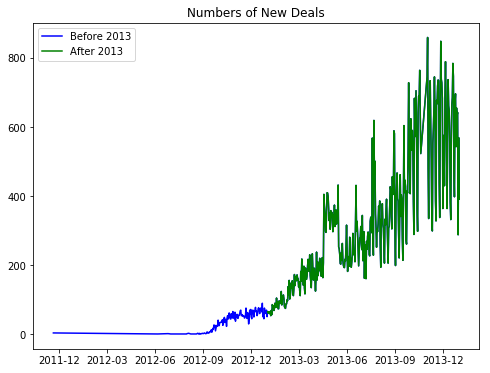

In [19]:
plt.figure(figsize=(8,6))
plt.plot(number_new_deals, color='blue')
plt.plot(number_new_deals_2013, color='green')
#count.plot()
#count2013.plot()
plt.legend(["Before 2013","After 2013"],loc='upper left')
plt.title('Numbers of New Deals' )
plt.show()   
 

In [20]:
df_number_new_deals_2013 = {'Date':number_new_deals_2013.index,'Count':number_new_deals_2013.values}
df_number_new_deals_2013 = pd.DataFrame(df_number_new_deals_2013)

In [21]:
month = df_number_new_deals_2013['Date'].dt.month
weekday = df_number_new_deals_2013['Date'].dt.weekday
df_number_new_deals_2013.insert(2,'Month', month)
df_number_new_deals_2013.insert(2,'Weekday', weekday)

In [22]:
dummy_month = pd.get_dummies(df_number_new_deals_2013['Month'],prefix='Month' )
dummy_weekday = pd.get_dummies(df_number_new_deals_2013['Weekday'],prefix='Weekday')
df_number_new_deals_2013 = pd.concat([df_number_new_deals_2013,dummy_month,dummy_weekday],axis = 1)
df_number_new_deals_2013 = df_number_new_deals_2013.drop(columns=['Date','Month','Weekday'])

In [23]:
df_number_new_deals_2013.head()

,Count,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,65,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,65,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,65,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
y = df_number_new_deals_2013.iloc[:,0]
x = df_number_new_deals_2013.iloc[:,1:]

In [25]:
model = sm.OLS(y, x).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     80.85
Date:                Mon, 06 Apr 2020   Prob (F-statistic):          1.51e-107
Time:                        22:51:47   Log-Likelihood:                -2071.2
No. Observations:                 354   AIC:                             4178.
Df Residuals:                     336   BIC:                             4248.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month_1     -130.7687     14.959     -8.742      0.0

In [26]:
predict_days = pd.date_range(start='20131020', end='20131030')
predict_x = {'Date':predict_days}
predict_x = pd.DataFrame(predict_x)
predict_month = predict_x['Date'].dt.month
predict_weekday = predict_x['Date'].dt.weekday
predict_x.insert(1,'Month', predict_month)
predict_x.insert(1,'Weekday', predict_weekday)

In [27]:
predict_dummy_month = pd.get_dummies(predict_x['Month'],prefix='Month' )
predict_dummy_weekday = pd.get_dummies(predict_x['Weekday'],prefix='Weekday')
predict_x = pd.concat([predict_x,predict_dummy_month,predict_dummy_weekday],axis = 1)
predict_x = predict_x.drop(columns=['Date','Month','Weekday'])

In [28]:
predict_x.head()

,Month_10,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0
3,1,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0


In [29]:
zero = np.zeros((11,1)).astype(np.uint8)
predict_x.insert(1,'Month_12', zero)
predict_x.insert(1,'Month_11', zero)
predict_x.insert(0,'Month_9', zero)
predict_x.insert(0,'Month_8', zero)
predict_x.insert(0,'Month_7', zero)
predict_x.insert(0,'Month_6', zero)
predict_x.insert(0,'Month_5', zero)
predict_x.insert(0,'Month_4', zero)
predict_x.insert(0,'Month_3', zero)
predict_x.insert(0,'Month_2', zero)
predict_x.insert(0,'Month_1', zero)

In [30]:
predict_x.head()

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [31]:
y_predict = model.predict(predict_x)

### Active Days

In [32]:
start_2014 = pd.to_datetime('2014-01-01')
days_to_end = (start_2014 - predict_days)
missing = {'Date':predict_days, 'Days to End':days_to_end.days, 'New Deals':y_predict}
missing = pd.DataFrame(missing)

In [33]:
missing

,Date,Days to End,New Deals
0,2013-10-20,73,475.265556
1,2013-10-21,72,572.612366
2,2013-10-22,71,582.461159
3,2013-10-23,70,595.930277
4,2013-10-24,69,616.980364
5,2013-10-25,68,595.112094
6,2013-10-26,67,514.937369
7,2013-10-27,66,475.265556
8,2013-10-28,65,572.612366
9,2013-10-29,64,582.461159


### Average Daily Billings

In [34]:
daily_billing_10_11 = local[(local['Start Date'] >= '2013-10-01')&(local['Start Date'] < '2013-12-01')]
daily_billing_10_11_mean = daily_billing_10_11['Daily Billings'].mean()

In [35]:
daily_billing_10_11_mean

103.13455463038575

In [36]:
misssing_billings = missing['Days to End']*missing['New Deals']*daily_billing_10_11_mean

## Billings Estimate by Segment

In [37]:
Local_billings = local['Billings'].sum() + misssing_billings.sum()

Goods = df_cleaned[(df_cleaned['Segment'] == 'Goods')]
Goods_billings = Goods['Billings'].sum() 

Travel = df_cleaned[(df_cleaned['Segment'] == 'Travel')]
Travel_billings = Travel['Billings'].sum() 

Total_billings = df_cleaned['Billings'].sum() + misssing_billings.sum()

In [38]:
print('Gross billings of Local Segment：', Local_billings)
print('Gross billings of Goods Segment：', Goods_billings)
print('Gross billings of Travel Segment：', Travel_billings)
print('Total gross billings：', Total_billings)

Gross billings of Local Segment： 452532531.1526092
Gross billings of Goods Segment： 282245469.10132
Gross billings of Travel Segment： 70547395.7245
Total gross billings： 805325395.9784293


In [39]:
Local_billings + Goods_billings + Travel_billings

805325395.9784293